<a href="http://landlab.github.io"><img style="float: left" src="../../../landlab_header.png"></a>

# Linear diffusion exercise with Landlab

This notebook is adapted from *Landscape Evolution Modeling with CHILD* by Gregory Tucker and Stephen Lancaster. This notebook was created by Nicole Gasparini at Tulane University.

<hr>
For tutorials on learning Landlab, click here: <a href="https://github.com/landlab/landlab/wiki/Tutorials">https://github.com/landlab/landlab/wiki/Tutorials</a>
<hr>


**What is this notebook?**

This notebook illustrates how hillsloeps change over time when processes like animals burrowing and freeze-thaw cycles slowly move sediment downhill. These processes can be modeled using the linear diffusion equation. In other words, the downhill flow of soil is proportional to the (downhill) gradient (slope) of the land surface multiplied by a transport coefficient.

The notebook first illustrates a simple example of a hillslope modeled using the linear diffusion equation. We then provide a number of exercises for students to do on their own. This set of exercises is recomended for students in a quantitative geomorphology class, who have been introduced to the linear diffusion equation in class. 

**Application of linear diffusion transport law:**

For relatively gentle, soil-mantled slopes, sediment transport can be approximated using the linear diffusion equation:
\begin{equation}
q_s = -D \nabla z
\end{equation}
where ${q}_s$ is the transport rate with dimensions of L$^2$T$^{-1}$;  $D$ is a transport coefficient with dimensions of L$^2$T$^{-1}$; and $z$ is elevation (dimensions L). $\nabla z$ is the gradient in elevation. If distance is increasing downslope, $\nabla z$ is negative downslope, hence the negative in front of $D$. 
 
The rate of change in elevation, i.e. erosion or deposition, is calculated from conservation of mass:
\begin{equation}
\frac{dz}{dt} = U-\nabla q_s
\end{equation}
where $U$ is the rock uplift rate, with dimensions LT$^{-1}$. We include a rock uplift term so that the hillslope can reach a steady state. Here steady state means that erosion is equal to the input of material from below (from rock uplift). At steady state, the elevation of the hillslope doesn't change. This model will also assume that all sediment flux at the bottom of the hillslope is removed, and the process responsible for removing sediment would likely be a river at the toe of the hillslope. This set-up and theoretical steady-state are useful for comparing model predictions.

Note that this setup is equivalent to a steady erosion, likely from a river, at the toe of a hillslope. In this case there would be no rock uplift and the hillslope elevation would be going down steadily and uniformly once steady state is reached, but the form of the hillslope would not change.

Everywhere in this notebook steady means not changing in time and uniform means not changing in space.

**How will we explore this with Landlab?**

We will use the Landlab component *LinearDiffuser*, which implements the equations above, to explore how hillslopes change shape when linear diffusion is used to model hillslope sediment transport. We will explore both steady state and also how a landscape may transition to steady state.

The first example illustrates how to set-up the model and evolve a hillslope to steady state, along with how to plot some variables of interest. We assume that you have knowledge of how to derive the steady-state form of a uniformly uplifting, diffusive hillslope. For more information on hillslope sediment transport laws, this paper is a great overview:

Roering, Joshua J. (2008) "How well can hillslope evolution models “explain” topography? Simulating soil transport and production with high-resolution topographic data." Geological Society of America Bulletin.

Based on the first example, you are asked to think about what will happen as you change a parameter, and then you explore this numerically by changing the code.

**How to run this notebook**

Start at the top by reading each block of text and sequentially running each code block (shift - enter OR got to the _Run_ pulldown menu at the top that has different options). 

Remember that you can always go to the _Kernel_ pulldown menu at the top and choose _Restart & Clear Output_ or _Restart & Run All_ if you change things and want to start afresh. If you just change one code block and rerun only that code block, only the parts of the code in that code block will be updated. (E.g. if you change parameters but don't first rerun the code blocks that initialize run time or topography, the changed parameters will apply on the existing hillslope.) 

**Let's go!**

Note that if you are running this on the CSDMS Jupyter Hub, you should be in the CSDMS kernel. (_Kernel_ pulldown menu, _Change Kernel..._ 

In [ ]:
# below is to make plots show up in the notebook
%matplotlib inline

Below are import statements. You should not need to change these.

In [1]:
# Code Block 1

import numpy as np
from matplotlib.pyplot import figure, legend, plot, show, title, xlabel, ylabel, ylim

from landlab.plot.imshow import imshow_grid

We will create a grid with 41 rows and 5 columns, and dx is 5 m (a long, narrow, hillslope). The initial elevation is 0 at all nodes.

We set-up boundary conditions so that material can leave the hillslope at the two short ends.

In [2]:
# Code Block 2

# setup grid
from landlab import RasterModelGrid

mg = RasterModelGrid((41, 5), 5.0)
z_vals = mg.add_zeros("topographic__elevation", at="node")

# initialize some values for plotting
ycoord_rast = mg.node_vector_to_raster(mg.node_y)
ys_grid = ycoord_rast[:, 2]

# set boundary condition.
mg.set_closed_boundaries_at_grid_edges(True, False, True, False)

Now we import and initialize the *LinearDiffuser* component. 

In [3]:
# Code Block 3

from landlab.components import LinearDiffuser

D = 0.01  # initial value of 0.01 m^2/yr
lin_diffuse = LinearDiffuser(mg, linear_diffusivity=D)

We now initialize a few more parameters.

In [4]:
# Code Block 4

# Uniform rate of rock uplift
uplift_rate = 0.0001  # meters/year, originally set to 0.0001

# Total time in years that the model will run for.
runtime = 1000000  # years, originally set to 1,000,000

# Stability criteria for timestep dt.  Coefficient,
# initially set at 0.5, can be changed depending on
# our tolerance for stability (lower value) vs 
# tolerance for run time (higher value means it takes longer to run).
dt = 0.5 * mg.dx * mg.dx / D

# nt is number of time steps
nt = int(runtime // dt)

# Below is to keep track of time for labeling plots
time_counter = 0

# length of uplift over a single time step, meters
uplift_per_step = uplift_rate * dt

Now we figure out the analytical solution for the elevation of the steady-state profile. (Hopefully you have already done this in class.)

In [5]:
# Code Block 5

ys = np.arange(mg.number_of_node_rows * mg.dx - mg.dx)

# location of divide or ridge crest -> middle of grid
# based on boundary conds.
divide_loc = (mg.number_of_node_rows * mg.dx - mg.dx) / 2

# half-width of the ridge
half_width = (mg.number_of_node_rows * mg.dx - mg.dx) / 2

# analytical solution for elevation under linear diffusion at steady state
zs = (uplift_rate / (2 * D)) * (np.power(half_width, 2) - np.power(ys - divide_loc, 2))

Let's look at the starting topography that we set-up in Code Block 2. (If you didn't change anything, it should be flat with zero elevation.)

Text(0.5, 1.0, 'initial topographic cross section')

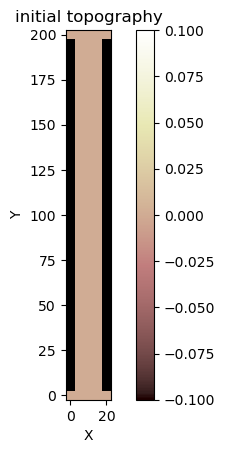

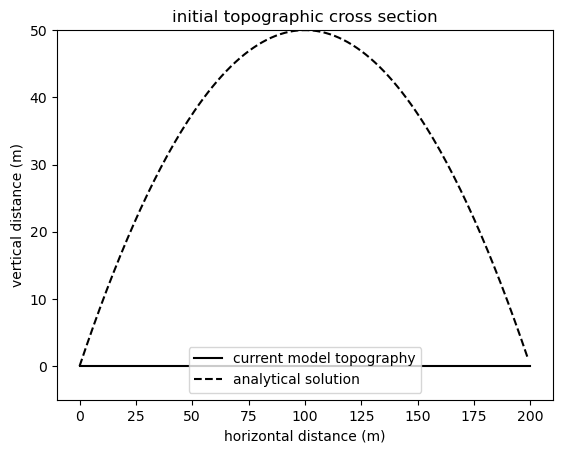

In [6]:
# Code Block 6

figure(1)
imshow_grid(mg, "topographic__elevation")
title("initial topography")
figure(2)
elev_rast = mg.node_vector_to_raster(mg.at_node["topographic__elevation"])
plot(ys_grid, elev_rast[:, 2], "k-", label="current model topography")
plot(ys, zs, "k--", label="analytical solution")
ylim((-5, 50))  # may want to change upper limit if D changes
xlabel("horizontal distance (m)")
ylabel("vertical distance (m)")
legend(loc="lower center")
title("initial topographic cross section")

Now we are ready to run the model. Above we can see that the topography is currently flat - no change in color on the raster map above. (The black cells on the east and west of the grid are boundaries and not part of the model calculations). The line plot below the raster map is a cross section, or line up the middle of the hillslope, from south to north. This cross section shows the shape of the hillslope in 2D, and we will use only cross-sections from here on. The current model topography (black, solid line) is flat. At steady state, the equations predict it will have the form of the black, dashed line. 

The time loop below contains all the process parts of the model. First all points on the hillslope are uplifted (elevation increases). Then diffusion is applied, moving material downslope.

The hillslope halfway through the time loop will plot below Code Block 7.

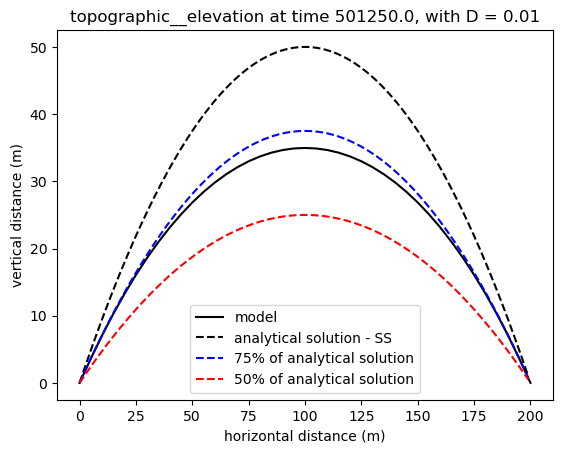

In [7]:
# Code Block 7

for i in range(nt):
    mg["node"]["topographic__elevation"][mg.core_nodes] += uplift_per_step
    lin_diffuse.run_one_step(dt)
    time_counter += dt

    # All landscape evolution is the first two lines of loop.
    # Below is simply for plotting the topography halfway through the run
    if i == int(nt // 2):
        figure(1)
        elev_rast = mg.node_vector_to_raster(mg.at_node["topographic__elevation"])
        plot(ys_grid, elev_rast[:, 2], "k-", label="model")
        plot(ys, zs, "k--", label="analytical solution - SS")
        plot(ys, zs * 0.75, "b--", label="75% of analytical solution")
        plot(ys, zs * 0.5, "r--", label="50% of analytical solution")
        xlabel("horizontal distance (m)")
        ylabel("vertical distance (m)")
        legend(loc="lower center")
        title("topographic__elevation at time %s, with D = %s" % (time_counter, D))

Now we plot the final cross-section.

Text(0.5, 1.0, 'topographic cross section at time 1000000.0, with D = 0.01')

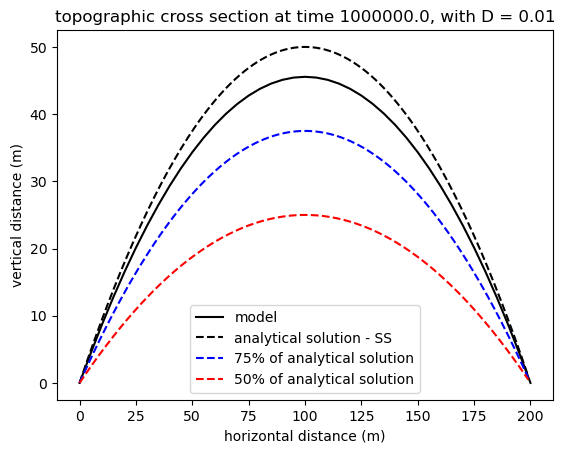

In [8]:
# Code Block 8

elev_rast = mg.node_vector_to_raster(mg.at_node["topographic__elevation"])
plot(ys_grid, elev_rast[:, 2], "k-", label="model")
plot(ys, zs, "k--", label="analytical solution - SS")
plot(ys, zs * 0.75, "b--", label="75% of analytical solution")
plot(ys, zs * 0.5, "r--", label="50% of analytical solution")
xlabel("horizontal distance (m)")
ylabel("vertical distance (m)")
legend(loc="lower center")
title("topographic cross section at time %s, with D = %s" % (time_counter, D))

Now we plot the slope in the downward direction across the landscape.

In [ ]:
# Code Block 9

from landlab.components import FlowAccumulator

fr = FlowAccumulator(mg)  # intializing flow routing
fr.run_one_step()
plot(
    mg.node_y[mg.core_nodes],
    mg.at_node["topographic__steepest_slope"][mg.core_nodes],
    "k-",
)
xlabel("horizontal distance (m)")
ylabel("topographic slope (m/m)")
title("slope of the hillslope at time %s, with D = %s" % (time_counter, D))

In [ ]:
# Code Block 10

#from landlab.utils import window_statistic

#radius = 15

#relief = calculate_window_statistic(mg,"topographic__elevation", np.ptp,search_radius=radius, calc_on_closed_nodes=False,)

#figure(1)
#imshow_grid(mg, relief)
#title("map of local relief with window radius = %s" % (radius))

Has the landscape reached steady state yet? How do you know?







Answer: Not quite, because the modeled topography (black, solid line in plot after Code Block 8) has not yet reached the analytical solution (black dashed line). Go back and rerun Code Blocks 7, 8 and 9 (time loop and plotting). (Remember you can rerun a cell with shift-return, or from the kernel pull-down menu.) Has it reached steady state yet?  

**What to do and hand in:**
1. Run the example provided ($D$ = 0.01 m$^2$yr$^{-1}$ and $U$ = 0.0001 m yr$^{-1}$) to steady state. Save a plot of the final cross section to hand in. What is the total relief on the hillslope (maximum elevation minus minimum elevation, approximate is fine)? What is happening to the slope across the hillslope (plot after code block 9)? Why is the change in slope necessary at steady state? (Answer questions with one or two sentences at most.)
2. How do you think the relief and slopes would change if you increase $D$ to 0.1 m$^2$yr$^{-1}$? In four sentences or less, describe what you think will happen and why. Use the equations to help you with your prediction.
3. Now, in Code Block 3, set $D$ = 0.1 m$^2$yr$^{-1}$ and rerun the hillslope evolution from an initial flat. Save a plot of the final cross section to hand in. Discuss how the hillslope differs from the results in question 1. Discuss how the results are similar to or different from your prediction in question 2. It is OK if your intuition was wrong! If you were wrong, can you see why from the equations after a second look?
4. What do you think will happen when you increase **uplift_rate** (Code Block 4) by a factor of 10?  Will the topography be different? Will the relieve and slopes change? If yes, how and why? Answer these questions first, and then rerun the code with **uplift_rate** = 0.001 m yr$^{-1}$. (Make sure you change $D$ - Code Block 3 - back to the original value of 0.01 m$^2$yr$^{-1}$ and restart from a flat surface.) Illustrate the final steady state topography. Discuss how these results differ from the results in question 1 and how the results match (or do not) your intuition. It is OK if your intuition was wrong.

You should hand in a typed document that answers the above questions with supporting plots. Plots should be embedded in the text, or, if they all fall at the end, they need to be clearly labeled, e.g. each plot has a figure number and plots are referred to by figure number in the text.

Other questions you can explore.

1. Does grid resolution affect your answers? If so, how?
